In [1]:
import requests
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Get the word lists from the source code

r = requests.get('https://www.powerlanguage.co.uk/wordle/main.e65ce0a5.js')

# This regexp pulls the word lists out of the source
solutions, guesses = [re.findall('\w{5}', m.group(0)) for m in re.finditer('\[("\w{5}",?)+\]', r.text)]
guesses = guesses + solutions
len(solutions), len(guesses)

(2315, 12972)

In [3]:
# Write the word lists to local files

with open('solutions.txt', 'wt') as sol_file:
    sol_file.write('\n'.join(solutions))

with open('guesses.txt', 'wt') as guess_file:
    guess_file.write('\n'.join(guesses))


In [4]:
# Count the frequency of letters by position

appearances = {}

for word in solutions:
    for i, c in enumerate(word):
        count = appearances.get((c, i), 0) + 1
        appearances[(c, i)] = count

print(appearances)

{('c', 0): 198, ('i', 1): 202, ('g', 2): 67, ('a', 3): 163, ('r', 4): 212, ('r', 0): 105, ('e', 1): 242, ('b', 2): 57, ('u', 3): 82, ('t', 4): 253, ('s', 0): 366, ('s', 2): 80, ('s', 3): 171, ('y', 4): 364, ('h', 0): 69, ('u', 1): 186, ('m', 2): 61, ('p', 3): 50, ('h', 4): 139, ('a', 0): 141, ('w', 1): 44, ('a', 2): 307, ('k', 3): 55, ('e', 4): 424, ('b', 0): 173, ('l', 1): 201, ('u', 2): 165, ('f', 0): 136, ('o', 1): 279, ('c', 2): 56, ('l', 4): 156, ('e', 0): 72, ('v', 1): 15, ('d', 3): 69, ('n', 0): 37, ('a', 1): 304, ('v', 2): 49, ('r', 2): 163, ('v', 3): 46, ('t', 3): 139, ('d', 0): 111, ('r', 3): 152, ('f', 4): 26, ('m', 0): 107, ('d', 2): 75, ('e', 3): 318, ('k', 0): 20, ('m', 3): 68, ('a', 4): 64, ('t', 1): 77, ('i', 2): 266, ('n', 3): 182, ('k', 4): 113, ('g', 0): 115, ('r', 1): 267, ('q', 0): 23, ('n', 2): 139, ('c', 3): 152, ('b', 1): 16, ('g', 3): 76, ('n', 4): 130, ('j', 2): 3, ('o', 3): 132, ('e', 2): 177, ('o', 2): 244, ('l', 2): 112, ('t', 2): 111, ('p', 0): 142, ('s', 

In [5]:
# summarize the appearances

letter_counts = pd.DataFrame({chr(o): [appearances.get((chr(o), i), 0) for i in range(5)] for o in range (97, 97+26)}).T
letter_counts

,0,1,2,3,4
a,141,304,307,163,64
b,173,16,57,24,11
c,198,40,56,152,31
d,111,20,75,69,118
e,72,242,177,318,424
f,136,8,25,35,26
g,115,12,67,76,41
h,69,144,9,28,139
i,34,202,266,158,11
j,20,2,3,2,0


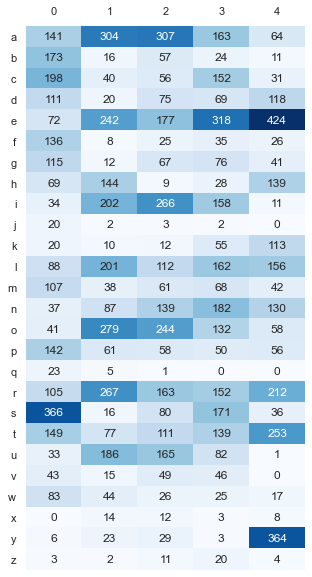

In [6]:

sns.set(rc = {'figure.figsize':(5,10)})
sns.heatmap(letter_counts, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.yticks(rotation=0) 
plt.tick_params(labelbottom = False, bottom=False, top = False, labeltop=True)

plt.show()

In [7]:


def get_green_ct(word):
    return sum([appearances.get((c, i), 0) for i, c in enumerate(word)])

greens = {word: get_green_ct(word) for word in guesses}
max(greens, key = greens.get)

'saree'

In [8]:
df = pd.DataFrame.from_dict(greens, orient='index').rename(columns={0: 'ct'})

(df['ct']/len(solutions)).nlargest(25)

saree    0.680346
sooey    0.678618
soree    0.669546
saine    0.666091
soare    0.660043
saice    0.653132
sease    0.652268
seare    0.644060
seine    0.639309
slane    0.639309
soole    0.637149
siree    0.636285
seise    0.634557
cooee    0.631965
soote    0.627214
soily    0.620734
slate    0.620734
soave    0.614255
samey    0.610367
semee    0.609503
sauce    0.609503
slice    0.608639
seame    0.607775
souse    0.606911
cooey    0.606048
Name: ct, dtype: float64

In [9]:
get_green_ct('eeeee')

1233

In [10]:
word = 'saree'
for i, c in enumerate(word):
    print (appearances.get((c, i), 0))

366
304
163
318
424


In [11]:
def grade_guess(sol, guess):
    response = []
    for i, c in enumerate(guess):
        if sol[i] == c:
            response.append(True)
        elif c in sol:
            response.append(False)
        else:
            response.append(None)
    return tuple(response)

grade_guess('panic', 'disco')

(None, False, None, False, None)

In [12]:
grade_guess('panic', 'paint')

(True, True, False, False, None)

In [13]:

def grade_seed_word(guess):
    grades = {sol: grade_guess(sol, guess) for sol in solutions}

    # Now look for matches
    avg_matches = sum(np.square(pd.Series(grades).value_counts().values))/len(solutions)
    #avg_matches = sum(sum(grades[sol] == g for g in grades.values()) for sol in solutions)/len(solutions)
    print(guess, avg_matches)
    return avg_matches

seed_word_scores = pd.Series({guess: grade_seed_word(guess) for guess in guesses})



aahed 194.8401727861771
aalii 312.33563714902806
aargh 248.68984881209502
aarti 151.414686825054
abaca 509.71274298056153
abaci 292.28034557235424
abacs 296.1257019438445
abaft 346.8479481641469
abaka 650.1550755939525
abamp 435.16069114470844
aband 330.60777537796974
abash 305.88725701943844
abask 375.98833693304533
abaya 532.7321814254859
abbas 472.54470842332614
abbed 259.45788336933043
abbes 205.42246220302377
abcee 204.9170626349892
abeam 276.3002159827214
abear 180.64665226781858
abele 185.5684665226782
abers 115.1658747300216
abets 128.30799136069115
abies 107.96155507559395
abler 107.98401727861771
ables 118.3745140388769
ablet 107.6012958963283
ablow 239.741252699784
abmho 270.9403887688985
abohm 253.76198704103672
aboil 153.2341252699784
aboma 354.9386609071274
aboon 286.9879049676026
abord 170.84967602591792
abore 97.46479481641468
abram 310.0021598272138
abray 271.79568034557235
abrim 181.27818574514038
abrin 143.25831533477321
abris 133.52958963282938
absey 135.20561555075

In [14]:
seed_word_scores.nsmallest(20)

roate    60.424622
raise    61.000864
raile    61.330886
soare    62.301080
arise    63.725702
irate    63.779266
orate    63.890713
ariel    65.287689
arose    66.021166
raine    67.056156
artel    67.495896
taler    67.736933
ratel    69.843197
aesir    69.882937
arles    69.890713
realo    69.947732
alter    69.991793
saner    70.125702
later    70.223326
snare    71.097624
dtype: float64

<AxesSubplot:>

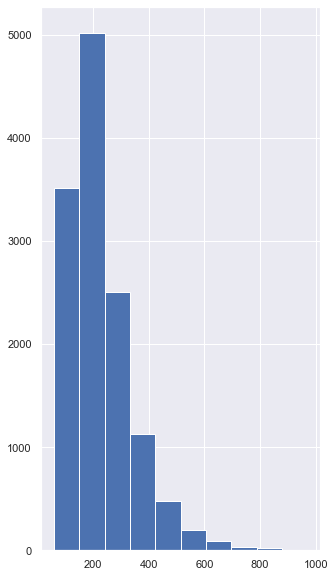

In [15]:
seed_word_scores.hist()

In [19]:

guess_pool = seed_word_scores.nsmallest(20).index
all_guess_grades = {(sol, guess): grade_guess(sol, guess) for sol in solutions for guess in guess_pool}
pair_performance = {(guess1, guess2): grade_seed_word_pair(guess1, guess2) for guess1 in guess_pool for guess2 in guess_pool if guess1<guess2}



roate soare 32.398704103671705
roate taler 24.252699784017278
roate saner 14.850539956803456
roate snare 18.74168466522678
raise roate 16.614686825053997
raise soare 26.904967602591793
raise taler 15.931317494600432
raise ratel 17.425053995680347
raise realo 16.55939524838013
raise saner 28.984449244060475
raise snare 29.817278617710585
raile roate 15.63585313174946
raile raise 34.09460043196544
raile soare 15.425053995680345
raile raine 36.58358531317494
raile taler 26.871274298056157
raile ratel 29.005183585313176
raile realo 28.891144708423326
raile saner 16.177537796976242
raile snare 16.725269978401727
soare taler 13.924406047516198
arise roate 15.535637149028078
arise raise 51.36630669546436
arise raile 28.013390928725702
arise soare 27.517494600431966
arise irate 31.055291576673866
arise orate 18.79524838012959
arise arose 36.266522678185744
arise raine 30.122246220302376
arise artel 17.003455723542118
arise taler 14.174082073434125
arise ratel 14.348596112311014
arise arles 29.

In [20]:
def grade_seed_word_pair(guess1, guess2):
    grades = {sol: (all_guess_grades[(sol, guess1)], all_guess_grades[(sol, guess2)]) for sol in solutions}

    # Now look for matches
    avg_matches = sum(np.square(pd.Series(grades).value_counts().values))/len(solutions)
    #avg_matches = sum(sum(grades[sol] == g for g in grades.values()) for sol in solutions)/len(solutions)
    print(guess1, guess2, avg_matches)
    return avg_matches

grade_seed_word_pair('raise', 'soare')

raise soare 26.904967602591793


26.904967602591793

In [21]:
df = pd.DataFrame.from_dict(pair_performance, orient='index').rename(columns={0: 'power'})
df['power'].nsmallest(25)

(ariel, roate)    12.789201
(soare, taler)    13.924406
(alter, soare)    13.946004
(ariel, soare)    14.120518
(artel, soare)    14.170626
(arise, taler)    14.174082
(arles, roate)    14.282937
(arise, ratel)    14.348596
(artel, raise)    14.348596
(later, soare)    14.368467
(arise, later)    14.423758
(arose, taler)    14.453132
(ratel, soare)    14.526566
(arose, ratel)    14.558531
(alter, raise)    14.628510
(arose, later)    14.749460
(arise, realo)    14.790065
(roate, saner)    14.850540
(artel, raine)    15.027646
(aesir, roate)    15.053564
(ariel, snare)    15.220302
(alter, arise)    15.345572
(raile, soare)    15.425054
(ariel, orate)    15.461339
(arles, raine)    15.487257
Name: power, dtype: float64